# Human Evaluation

In this notebook we focus on parsing, aggregating and forming useful insights on the human evaluation output.

In [2]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes
sns.set_palette("deep")

In [3]:
EVALUATED_PATH = "../storage/results/human_evaluation/cordis/out/curated_cordis_no_query_t5_small_full_totto.json"

with open(EVALUATED_PATH) as f:
    evaluations = json.load(f)

## Count per category

In [4]:
evaluation_choices = [evaluation['evaluation'].split(',') for evaluation in evaluations]
flattened_choices = [flattened_evaluation for evaluation in evaluation_choices for flattened_evaluation in evaluation]

summed_choices = Counter(flattened_choices)
print(summed_choices)

percentage_choices = {key: val / len(evaluation_choices) for key, val in summed_choices.items()}
print(percentage_choices)

Counter({'Erroneous': 34, 'Correct': 21, 'Omission': 9})
{'Omission': 0.16071428571428573, 'Erroneous': 0.6071428571428571, 'Correct': 0.375}


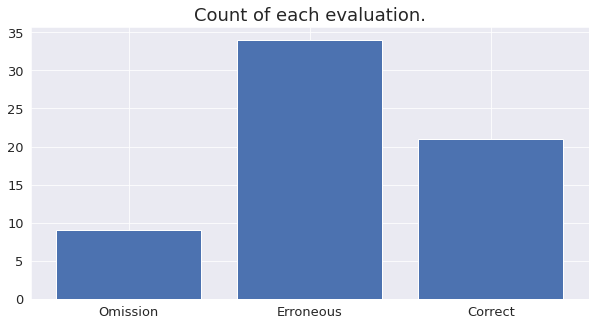

In [5]:
plt.figure(figsize=(10,5))

plt.bar(summed_choices.keys(), summed_choices.values())
plt.title("Count of each evaluation.")
plt.show()

## Inference examples

In [7]:
category = "Erroneous"

for evaluation in evaluations:
    if category in evaluation['evaluation']:
        print("-"*100)
        print(f"Target: {evaluation['target']}\n")
        print(f"Predicted: {evaluation['predicted']}\n")
        print(f"Source: {evaluation['source']}\n")
        print("-"*100)

----------------------------------------------------------------------------------------------------
Target: The project titled 'The impact of the quality of CO2 on transport and storage behaviour', with the call FP7-ENERGY-2012-1-2STAGE, was under the fund sceme CP, a cordis reference id '106656', ec reference 308809. The project started in 2013 and ended in 2015, had a total cost of 5573556, with a max contribution of 4000764.5 under the framework programm FP7.

Predicted: The impact of the quality of CO2 on transport and storage behaviour was 143717 (CP, 106656), 308809 (nan), 5573556 (nan) and 4000764.5 (FP7).

Source: <page_title> projects </page_title> <section_title> projects </section_title> <table> <cell> 143717 <col_header> unics_id </col_header> </cell> <cell> IMPACTS <col_header> acronym </col_header> </cell> <cell> The impact of the quality of CO2 on transport and storage behaviour <col_header> title </col_header> </cell> <cell> FP7-ENERGY-2012-1-2STAGE <col_header> ec_cal